# USD/MXN Exchange Rate during 2016 US Election Night

During the night of the 2016 US election night, we saw Donald Trump won the presidency while most polling agency predicted Hillary Clinton would be victorious. This came as a suprise to the most people. In this project I would like to how the financial market reacted during the election night.

## Background:
During the campaign Donald Trump repeatedly mentioned building a wall between the US and Mexico boarder, putting high import tariff on imported goods from Mexico and renegotiate or abandon NAFTA. All such action are seen as negatives for the Mexican economy whose biggest export market is the US. It is no suprise that in the event of a trump victory, the Mexican Peso will depreciate against other currencies.

In this project I will run a realtime analysis on Trumps victory chance and see how fast the financial market reacted as the result came out from each state.

In [1]:
# -*- coding: utf-8 -*-
"""
Created on Wed Aug  2 16:32:27 2017

@author: AlexH
"""

#Priors 1: state, number


#Updates & Results: state, time, number

#Step 1, get all data (use just website time info for now)

#Step 2, rolling regression

#Step 3, find error margin at each stage

#Step 4, compare with financial data
    

import numpy as np
import csv
import matplotlib.pyplot as plt
from sklearn import linear_model, datasets
import statsmodels.api as sm

import pandas as pd
from collections import OrderedDict
from datetime import date

from datetime import datetime
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
import pylab

import tweepy

import json

C:\Users\AlexH\Anaconda3\lib\site-packages\statsmodels\compat\pandas.py:56: FutureWarning: The pandas.core.datetools module is deprecated and will be removed in a future version. Please use the pandas.tseries module instead.
  from pandas.core import datetools


### Getting the Data

The data is collected from the internet, polling data is from Fivethrityeight 'prior-538.csv' and the election realtime data is recorded by watching BBC election live broadcast 'results.csv'.

In [2]:
#%%
#Reading in data


with open('data/prior-538.csv', newline='') as csvfile:
    data = csv.reader(csvfile, delimiter=',')
    prior=list(data)

prior = pd.DataFrame(prior)
prior.columns = ['State', 'poll', 'EV']


#with open('call-AP.csv', newline='') as csvfile:
#    data = csv.reader(csvfile, delimiter=',')
#    call=list(data)
#
#call = pd.DataFrame(call)
#call.columns = ['State', 'result', 'time']

with open('data/results.csv', newline='') as csvfile:
    data = csv.reader(csvfile, delimiter=',')
    result=list(data)

result = pd.DataFrame(result)
result.columns = ['State', 'result', 'time', 'trump', 'clinton', 'diff', 'intermediate','rprpc']


#join the table by state
jointb = prior.join(result.set_index('State'), on='State')
#order by time


#remove empty rows
jointb['EV'].replace('#N/A', np.nan, inplace=True)
jointb.dropna(subset=['EV'],inplace=True)

jointb = jointb.sort_values(by='time').reset_index(drop=True)
jointb.index = np.arange(0,len(jointb))
jointb[['poll', 'EV','result', 'trump', 'clinton', 'diff']]=jointb[['poll', 'EV','result', 'trump', 'clinton', 'diff']].apply(pd.to_numeric)



### Linear Regression and Monte Carlos Simulation



In [10]:

#storing result
columns = ['time', 'state','low', 'ave', 'high']
index= jointb.index
pred=pd.DataFrame(index=index, columns=columns)

#number of simulation for (a,b) and (error)
sim_num = 200
for i in range(3,len(jointb)-6):
    
    #fit linear regression
    select=jointb[0:i].drop_duplicates(subset='State', keep='last')
    X=select['poll'][0:i]
    Y=select['diff'][0:i]
    X=sm.add_constant(X)
    model = sm.RLM(Y, X).fit()
    
    #extract parameters
    const = np.random.normal(model.params[0], model.bse[0], sim_num)
    slope = np.random.normal(model.params[1], model.bse[1], sim_num)
    
    #make predictions, use states with no results and intermediate results
    remain=jointb[~jointb.State.isin(select.State)].drop_duplicates(subset='State', keep='last')
    for j in range(0, len(const)):
        error = np.random.normal(np.mean(model.resid), np.std(model.resid), sim_num)
        result = np.array([v + const[j] + slope[j]*remain['poll'] for v in error])
        result = result>0
        result = result.astype(int)
        
    #filling the result of intermediates states with current count
    select.result[select.result.isnull()[0:i]]=(select['diff'][select.result.isnull()[0:i]]>=0).astype(int)
    
    EEV=sum(select['result'][0:i] * select['EV'][0:i])+ np.dot(result, remain['EV'])
#    print(jointb['time'][i],jointb['State'][i], EEV)

    #make table for plot
    pred.time[i]=datetime.strptime(jointb.time[i], '%Y-%m-%d %H:%M')
    pred.state[i]=jointb.State[i]
    pred.low[i]=sorted(EEV)[int(sim_num/20)]
    pred.ave[i]=np.mean(EEV)
    pred.high[i]=sorted(EEV)[int(19*sim_num/20)]

# keep only the last value at a certain time. And remove NAs.
pred=pred.drop_duplicates(subset='time', keep='last').dropna(axis=0, how='all')
pred.index = np.arange(0,len(pred))

C:\Users\AlexH\Anaconda3\lib\site-packages\ipykernel_launcher.py:31: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy


In [11]:
#%%
# read the USD/MXN data
# data found here http://www.histdata.com/download-free-forex-historical-data/?/metatrader/1-minute-bar-quotes/usdmxn/2016
# my_data = np.genfromtxt('DAT_MT_USDMXN_M1_2016.csv', delimiter=',')


with open('data/DAT_MT_USDMXN_M1_2016.csv',newline='') as csvfile:
    data = csv.reader(csvfile, delimiter=',')
    fx=list(data)

fx = pd.DataFrame(fx)

#the sixth column is 0, drop it
fx = fx.drop(fx.columns[6], 1)

# average the minute values.
fx['mean'] = fx.ix[:,2:5].astype(float).mean(axis=1)

# extract time value to datetime format
fx['time'] = fx.ix[:,0]+fx.ix[:,1]
fx['time'] = [datetime.strptime(v, '%Y.%m.%d%H:%M') for v in fx['time']]

fx = fx.set_index(['time'])
fx = fx.loc[pred.time[0]:pred.time[len(pred)-1]]
fx = fx.drop(fx.columns[0:6],1)

C:\Users\AlexH\Anaconda3\lib\site-packages\ipykernel_launcher.py:17: DeprecationWarning: 
.ix is deprecated. Please use
.loc for label based indexing or
.iloc for positional indexing

See the documentation here:
http://pandas.pydata.org/pandas-docs/stable/indexing.html#deprecate_ix


### Plots

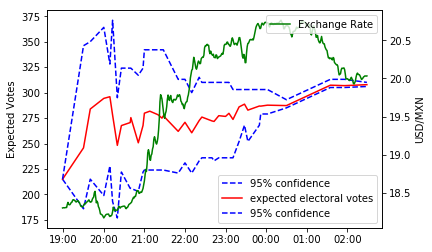

In [12]:
#%%
fig, ax1 = plt.subplots()
ax1.plot_date(pred.time, pred.low,'b--', label='95% confidence')
ax1.plot_date(pred.time, pred.ave,'r-', label='expected electoral votes')
ax1.plot_date(pred.time, pred.high,'b--', label='95% confidence')
plt.ylabel('Expected Votes')
pylab.legend(loc='lower right')

ax2 = ax1.twinx()
ax2.plot(fx['mean'],'g', label='Exchange Rate')

HMFmt = mdates.DateFormatter('%H:%M')
ax1.xaxis.set_major_formatter(HMFmt)
_ = plt.xticks(rotation=90)

plt.ylabel('USD/MXN')

pylab.legend(loc='upper right')
plt.show()


# UK 2017 Election - GBP/USD During UK 2017 Election Night - In Progress

## BBC Twitter Data

The realtime data will be retrieved from BBCs account as they anounce real-time the election result

In [8]:
CONSUMER_KEY = '4BByuBKYk19fpSl5iMIkju3c0'
CONSUMER_SECRET = '2EK91aT0s7uMJ1oWECBRUwkXrxGykigrsmtqtOIAvFBPXiucQq'
ACCESS_TOKEN = '892729320736739328-E30nIY5dacqxeugxPoe3TXB2fIjITZB'
ACCESS_TOKEN_SECRET = 'WMViNA7y1d1trkb5nt7L5dOAHdScmYBMHm33sLeUVZrWT'


auth = tweepy.OAuthHandler(CONSUMER_KEY, CONSUMER_SECRET)
auth.set_access_token(ACCESS_TOKEN, ACCESS_TOKEN_SECRET)
api = tweepy.API(auth)

tweets_raw = api.user_timeline(screen_name = 'bbcelection', count = 200, include_rts = False)
for i in range(0,5):
    oldest=tweets_raw[-1].id
    new_tweets = api.user_timeline(screen_name = 'bbcelection',count=200,max_id=oldest)
    tweets_raw.extend(new_tweets)

data = [[tw.created_at.year, tw.created_at.month, tw.created_at.day,"%s.%s"%(tw.created_at.hour, tw.created_at.minute), tw.id_str, tw.text.encode("utf8")] for tw in tweets_raw ]
tweets=pd.DataFrame(data, columns=['year','month','date','time','tweet_id','tweet'])


In [7]:
UKpoll=pd.DataFrame.from_csv('data/UK2017Poll.txt', sep='\t', header=0)

In [9]:
tweets


,year,month,date,time,tweet_id,tweet
0,2017,6,9,20.26,873275224090980352,"b'All the votes are counted, all the results a..."
1,2017,6,9,20.23,873274411654238209,b'Kensington: LAB win #GE2017. Full results: h...
2,2017,6,9,16.44,873219358939590656,"b'CORRECTION: Updated figures Southend West, C..."
3,2017,6,9,15.14,873196528923533312,b'Update: Correcting LAB number of votes. Winc...
4,2017,6,9,9.40,873112674753630212,b'Update 10:40am: Latest seat totals by party ...
5,2017,6,9,9.40,873112632907018240,"b'Updated result: Wells, CON hold #GE2017. See..."
6,2017,6,9,9.38,873112128621641729,b'CORRECTION: Updated image Redditch CON hold ...
7,2017,6,9,8.59,873102302113964033,b'Update 9:59am: Latest seat totals by party #...
8,2017,6,9,8.49,873099783061164033,b'Update 9:49am: Latest seat totals by party #...
9,2017,6,9,8.31,873095205984944129,b'Update 9:31am: Latest seat totals by party #...


In [13]:
model.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                    Robust linear Model Regression Results                    
==============================================================================
Dep. Variable:                   diff   No. Observations:                   49
Model:                            RLM   Df Residuals:                       47
Method:                          IRLS   Df Model:                            1
Norm:                          HuberT                                         
Scale Est.:                       mad                                         
Cov Type:                          H1                                         
Date:                Mon, 09 Oct 2017                                         
Time:                        10:50:53                                         
No. Iterations:                     8                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const          3.4030      0.509      6.681      0.000       2.405       4.401
poll           1.3032      0.028     46.932      0.000       1.249       1.358
==============================================================================

If the model instance has been used for another fit with different fit
parameters, then the fit options might not be the correct ones anymore .
"""